In [1]:
import arviz as az
from risk_experiment.cogmodels.fit_probit import build_model, get_data
from risk_experiment.cogmodels.utils import extract_intercept_gamma
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/Users/gdehol/mambaforge/lib/python3.10/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
bids_folder = '/data/ds-risk'

In [3]:
sessions = ['3t2', '7t2']

df = []
behavior = []

for session in sessions:
    data = get_data('probit_simple', session, bids_folder)
    behavior.append(data)
    model = build_model('probit_simple', data, session, bids_folder)
    idata = az.from_netcdf(f'/data/ds-risk/derivatives/cogmodels/model-probit_simple_ses-{session}_trace.netcdf')
    intercept, gamma = extract_intercept_gamma(idata, model, data)

    intercept = intercept.groupby('subject').mean().mean(1).rename('intercept')
    gamma = gamma.groupby('subject').mean().mean(1).rename('gamma')

    rnp = np.clip(np.exp(intercept/gamma),0, 1).rename('rnp')
    df.append(gamma.to_frame().join(rnp))

df = pd.concat(df, keys=sessions, names=['session'])
behavior = pd.concat(behavior, keys=sessions, names=['session'])

100%|██████████| 30/30 [00:01<00:00, 18.28it/s]


['subject', 'x', 'n_safe', 'risky_first']


100%|██████████| 30/30 [00:02<00:00, 14.62it/s]


['subject', 'x', 'n_safe', 'risky_first']


Text(0.5, 28.999999999999986, 'precision')

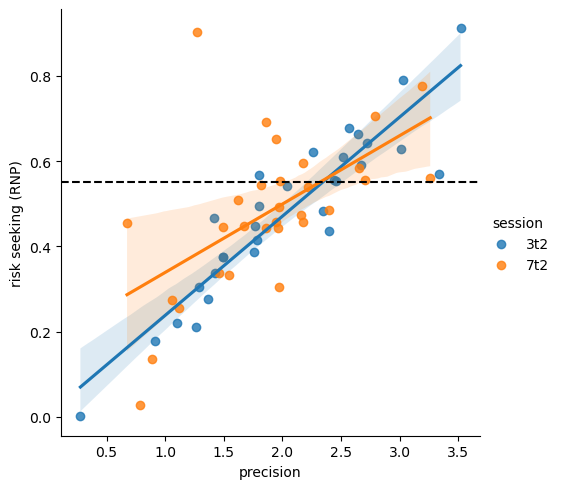

In [4]:
fac = sns.lmplot(df.reset_index(), x='gamma', y='rnp', hue='session')
plt.axhline(0.55, c='k', ls='--')
# fac.set(xlim=(0,1))
# plt.ylim(0, 1)

plt.ylabel('risk seeking (RNP)')
plt.xlabel('precision')

In [6]:
df.to_csv('/data/ds-risk/derivatives/cogmodels/gamma_rnp_simple.tsv', sep='\t')

In [33]:
import os.path as op
session = '3t2'

def get_risk_profile(row):

    if (row.high < 0.55):
        return 'risk-averse'
    elif (row.low > 0.55):
        return 'risk-seeking'
    else:
        return 'risk-neutral'

sessions = ['3t2', '7t2']
risk_profile = []
for session in sessions:
    data = get_data('probit_simple', session, bids_folder)
    model = build_model('probit_simple', data, session, bids_folder)
    intercept, gamma = extract_intercept_gamma(idata, model, data)
    rnp = np.clip(np.exp(intercept['intercept']/gamma['gamma']),0, 1).stack([0, 1]).to_frame('rnp')
    rnp_ci = rnp.groupby('subject').apply(lambda d: pd.Series(az.hdi(d.values[:, 0]), index=['low', 'high']))


    risk_profile.append(rnp_ci.apply(get_risk_profile, 1))

risk_profile = pd.concat(risk_profile, keys=sessions, names=['session']).to_frame('risk_profile')
risk_profile.to_csv(op.join(bids_folder, 'derivatives', 'cogmodels', 'simple_risk_preference.tsv'), sep='\t')

100%|██████████| 30/30 [00:01<00:00, 29.00it/s]


['subject', 'x', 'n_safe', 'risky_first']


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
100%|██████████| 30/30 [00:00<00:00, 31.07it/s]


['subject', 'x', 'n_safe', 'risky_first']


/Users/gdehol/mambaforge/lib/python3.10/site-packages/pandas/core/internals/blocks.py:352: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [32]:
risk_profile

risk_profile
session subject              
3t2     02       risk-neutral
        03       risk-neutral
        04       risk-neutral
        05        risk-averse
        06        risk-averse
        07        risk-averse
        08        risk-averse
        09       risk-neutral
        10        risk-averse
        11        risk-averse
        12       risk-neutral
        13       risk-neutral
        14       risk-neutral
        15        risk-averse
        16        risk-averse
        17       risk-seeking
        18       risk-seeking
        19       risk-seeking
        20        risk-averse
        21        risk-averse
        22        risk-averse
        23       risk-seeking
        25        risk-averse
        26        risk-averse
        27       risk-neutral
        28       risk-neutral
        29       risk-seeking
        30        risk-averse
        31        risk-averse
        32        risk-averse
7t2     02       risk-neutral
        03       risk-neutral
        04       risk-neutral
        05        risk-averse
        06        risk-averse
        07        risk-averse
        08        risk-averse
        09       risk-neutral
        10        risk-averse
        11        risk-averse
        12       risk-neutral
        13       risk-neutral
        14       risk-neutral
        15        risk-averse
        16        risk-averse
        17       risk-seeking
        18       risk-seeking
        19       risk-seeking
        20        risk-averse
        21        risk-averse
        22        risk-averse
        23       risk-seeking
        25        risk-averse
        26        risk-averse
        27       risk-neutral
        28       risk-neutral
        29       risk-seeking
        30        risk-averse
        31        risk-averse
        32        risk-averse

In [15]:
import os.path as op

In [26]:
from risk_experiment.utils.data import get_all_behavior

In [28]:
df = get_all_behavior(sessions=session, bids_folder=bids_folder, drop_outliers=False)

100%|██████████| 30/30 [00:01<00:00, 26.03it/s]


In [38]:
rnp = pd.read_csv(op.join(bids_folder, 'derivatives', 'cogmodels', 'gamma_rnp_simple.tsv'), sep='\t', index_col=[0,1], dtype={'subject':str})[['rnp']]
rnp['risk preference'] = (rnp['rnp'] > 0.55).map({True:'risk seeking', False:'risk averse'})

In [41]:
df.join(rnp)

rt  uncertainty  z_uncertainty  \
subject session run trial_nr                                         
02      7t2     1   1         1.544193          3.0       1.190537   
                    2         0.890433          3.0       1.190537   
                    3         1.707715          3.0       1.190537   
                    4         0.689762          2.0      -0.101466   
                    5         1.306945          2.0      -0.101466   
...                                ...          ...            ...   
32      7t2     8   188       0.574373          1.0      -0.535805   
                    189       0.424887          2.0       1.856628   
                    190       0.508297          1.0      -0.535805   
                    191       0.508506          1.0      -0.535805   
                    192       0.542275          2.0       1.856628   

                             median_split_uncertainty    n1    n2  prob1  \
subject session run trial_nr                                               
02      7t2     1   1                high uncertainty  19.0  10.0   0.55   
                    2                high uncertainty  98.0  28.0   0.55   
                    3                high uncertainty  52.0  20.0   0.55   
                    4                 low uncertainty  66.0  28.0   0.55   
                    5                 low uncertainty  17.0  10.0   0.55   
...                                               ...   ...   ...    ...   
32      7t2     8   188               low uncertainty  26.0  10.0   0.55   
                    189              high uncertainty  15.0   7.0   0.55   
                    190               low uncertainty  34.0  28.0   0.55   
                    191               low uncertainty  34.0  28.0   0.55   
                    192              high uncertainty  28.0   7.0   0.55   

                              prob2    p1   p2  ...  chose_risky        Order  \
subject session run trial_nr                    ...                             
02      7t2     1   1           1.0  0.55  1.0  ...        False  Risky first   
                    2           1.0  0.55  1.0  ...         True  Risky first   
                    3           1.0  0.55  1.0  ...         True  Risky first   
                    4           1.0  0.55  1.0  ...         True  Risky first   
                    5           1.0  0.55  1.0  ...         True  Risky first   
...                             ...   ...  ...  ...          ...          ...   
32      7t2     8   188         1.0  0.55  1.0  ...        False  Risky first   
                    189         1.0  0.55  1.0  ...        False  Risky first   
                    190         1.0  0.55  1.0  ...        False  Risky first   
                    191         1.0  0.55  1.0  ...        False  Risky first   
                    192         1.0  0.55  1.0  ...        False  Risky first   

                              n_risky  n_safe      frac  log(risky/safe)  \
subject session run trial_nr                                               
02      7t2     1   1            19.0    10.0  1.900000         0.641854   
                    2            98.0    28.0  3.500000         1.252763   
                    3            52.0    20.0  2.600000         0.955511   
                    4            66.0    28.0  2.357143         0.857450   
                    5            17.0    10.0  1.700000         0.530628   
...                               ...     ...       ...              ...   
32      7t2     8   188          26.0    10.0  2.600000         0.955511   
                    189          15.0     7.0  2.142857         0.762140   
                    190          34.0    28.0  1.214286         0.194156   
                    191          34.0    28.0  1.214286         0.194156   
                    192          28.0     7.0  4.000000         1.386294   

                             bin(risky/safe)   log(n1)       rnp  \
subject session run trial